# Analysis and modelling of bridge conditions in Texas



**Table of Contents**

1. Section 1: Introduction
2. Section 2: Data Preparation
  * Section 2.1: Data Cleansing
  * Section 2.2: Data Classification
3. Section 3: Exploratory Analysis
  * Section 3.1: Comparison among continuous data
  * Section 3.2: Comparison of continuous and categorical data
  * Section 3.3: Preliminary conclusions
4. Section 4: Regression Modelling
  * Section 4.1: Computing the linear regression model
  * Section 4.2: Error Distribution
  * Section 4.3: Comparing the Coefficients
  * Section 4.4: Final conclusions and brief suggestions

## Section 1: Introduction

This document examines data provided by National Bridge Inspection maintained by the Federal Highways Agency (FHWA), part of the US Department of Transportation. It consists of a table that contains various metrics concerning the condition of all existing bridges in the state of Texas.

I carry out an exploratory analysis of the data and then perform linear regression to determine whether the current condition of the bridges can be determined based on serval different attributes of the bridges. In particular, I use the attibutes *AverageDaily, Trucks_percent, Material, Design* and the derived attribute *Age* as independent variables which will predict the current condition of the bridges. I then combine the columns *Deck_rating, Superstr_rating* and *Substr_rating* into a column called *Current_condition* which will act as the dependent variable in the linear regression.

It is worth noting that that the data is only up to date for the year 2019. Therefore, the data doesn't contain any information about bridges build in 2020 or 2021 nor is the current state of the bridges updated with information collected in 2020 and 2021. Any mentions of 'current condition' in this document refer to the year 2019 and should be treated as being potentially outdated.

## Section 2: Data Preparation

Below, relevant table is imported and the various columns are catagorised according to whether they contain numerical data or categorical data. The resulting table consists of 34293 rows and 24 columns.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
%matplotlib inline

In [ ]:
rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent', 'NA'], 
    ordered=True)

scour_type = pd.CategoricalDtype(
    categories=['Unknown', 'Critical','Unstable', 'Stable', 'Protected', 'Dry', 'No waterway'], 
    ordered=True)

types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type, 
              'Scour_rating':scour_type}

bridges = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,3,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,1,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,4,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500


### Section 2.1: Data Cleansing

By looking at the table for missing data, we find seven rows which have missing data.

In [ ]:
bridges.loc[bridges.isnull().any(axis=1)]

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
010920004518118,District1,0,Free,State,Rural,Arterial,1970,2,2,7520,...,1,42.7,12.2,NaN,Good,Good,32.7,2.0,No waterway,10530
021200AA0205001,District2,11,Free,County,Rural,Local,1946,1,0,340,...,1,17.7,3.9,Good,NaN,Fair,11.8,0.0,Stable,390
031690AA0273001,District3,5,Free,County,Rural,Local,2008,2,0,20,...,1,12.2,7.2,NaN,Very Good,Very Good,32.7,0.0,Dry,40
121020B37610001,District12,2,Free,Town or City,Urban,Local,2008,2,0,100,...,1,15.2,8.2,NaN,Good,Good,32.7,0.0,Stable,150
131580AA0323001,District13,159,Free,County,Rural,Local,1999,1,0,60,...,1,8.5,6.0,NaN,Very Good,Good,32.7,0.0,Dry,100
190190102001006,District19,10,Free,State,Rural,Minor,1991,2,0,160,...,4,67.1,9.1,NaN,Good,Good,32.7,16.0,Dry,230
211090AA0348002,District21,6,Free,County,Rural,Local,1960,2,0,50,...,3,11.0,5.5,Failing,NaN,Poor,0.0,0.0,Stable,30


The rows with missing data are very small in number and are likely random in their distribution and are subsquently removed.


In [ ]:
bridges=bridges.loc[~bridges.isnull().any(axis=1)]
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,3,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,1,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,4,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500


I create a new column called *Age* which is derived by subtracting from the current year 2021 the year that each bridge was built.

In [ ]:
bridges=bridges.assign(Age=2021-bridges.Year)

I will now attempt to exclude very old bridges from my analysis. The initial thought process was to exclude historic bridges (i.e. bridges that are labeled as 'Register' in the *Historic* column. However, we find below that there are six historic bridges that are younger that 20 years old with the youngest one being just 3 years old.

In [ ]:
_a1=bridges.loc[(bridges.Historic == 'Register')]
_a1=_a1.loc[(bridges.Age < 20)]
_a1.style

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,Historic,Service_under,Material,Design,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Age
Structure_id,,,,,,,,,,,,,,,,,,,,,,,,,
030120AA0147001,District3,3,Free,County,Rural,Local,2016,2,0,10,Register,Highway,Concrete,Other,1,18.300000,7.400000,Very Good,Good,Very Good,32.700000,0.000000,Dry,20,5
030390028201124,District3,80,Free,State,Rural,Arterial,2018,2,0,1275,Register,Highway,Concrete,Beam,18,741.300000,13.400000,Good,Very Good,Good,32.700000,26.000000,Dry,1830,3
032440AA0339002,District3,8,Free,County,Rural,Local,2016,2,0,40,Register,Highway,Concrete,Beam,1,36.600000,7.300000,Very Good,Very Good,Good,32.700000,5.000000,Stable,80,5
041910053401005,District4,8,Free,State,Rural,Minor,2016,2,0,350,Register,Highway,Concrete,Beam,1,36.600000,8.500000,Good,Good,Very Good,32.700000,1.000000,Dry,390,5
080770AA0357002,District8,19,Free,Town or City,Rural,Local,2015,2,0,100,Register,Highway,Concrete,Beam,4,67.100000,7.300000,Good,Very Good,Good,32.700000,0.000000,Stable,50,6
232060AA0137003,District23,5,Free,County,Rural,Local,2017,2,0,50,Register,Highway,Concrete,Beam,1,39.600000,6.900000,Very Good,Very Good,Good,32.700000,2.000000,Stable,400,4


Based on the above, I therefore conclude that we can't use a bridge's historical status as a reliable indicator of how old it is. An alternative method of determining which bridges are very old is to create a boxplot, which is an easy way to visualise the outliers:

<AxesSubplot:>

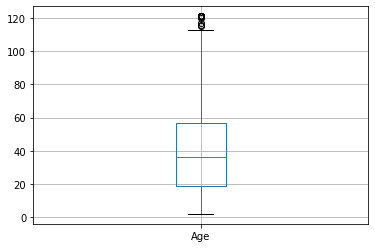

In [ ]:
bridges.boxplot(column=['Age'])

I now proceed to remove all outliers that have a value higher than the top whisker and thus represent very old bridges:

In [ ]:
Q1=bridges.Age.quantile(0.25)
Q3=bridges.Age.quantile(0.75)
bridges=bridges.loc[~(bridges.Age > Q3+1.5*(Q3-Q1))]
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Age
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1,16
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1,16
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150,9
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120,71
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600,27
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600,21
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500,25


### Section 2.2: Data Classification

I examine the different possible classifications of the bridges based on their material and their design. For the purposes of the regression modelling that I will be carrying out in section 4, I aim to reduce the number of categories that each bridge has by combining lesser used categories into a single one.

In [ ]:
bridges['Material'].value_counts()

Concrete    27121
Steel        6623
Timber        465
Other          48
Masonry        13
Name: Material, dtype: int64

In [ ]:
bridges['Design'].value_counts()

Beam          28322
Slab           4339
Other          1240
Arch            158
Truss           125
Frame            68
Movable          13
Suspension        5
Name: Design, dtype: int64

In the column *Material*, most bridges are are described as being made of concrete or steel while a minority are made of timber, masonry and other materials. Therefore, we create a new column called *Material_New* which groups the minority bridges into one category resulting in just three categories: *Concrete, Timber* and *Other_Materials*.

In the column *Design*, most bridges are described as beam or slab bridges while a minority are described as arch, truss, frame, movable, suspension or other. Therefore, we create a new column called *Design_New* which groups the minority bridges into one category resulting in just three categories: *Beam, Slab* and *Other_Designs*.

In [ ]:
def Material_classifier(row):
    if row.Material == 'Masonry' or row.Material == 'Timber' or row.Material == 'Other':
        return 'Other_Materials'
    return row.Material

def Design_classifier(row):
    if row.Design == 'Arch' or row.Design == 'Truss' or row.Design == 'Frame' or \
    row.Design == 'Movable' or row.Design == 'Suspension' or row.Design == 'Other':
        return 'Other_Designs'
    return row.Design

bridges = bridges.assign(Material_New = bridges.apply(Material_classifier, axis=1))
bridges = bridges.assign(Design_New = bridges.apply(Design_classifier, axis=1))

The categories of the new columns are presented below:

In [ ]:
bridges['Material_New'].value_counts()

Concrete           27121
Steel               6623
Other_Materials      526
Name: Material_New, dtype: int64

In [ ]:
bridges['Design_New'].value_counts()

Beam             28322
Slab              4339
Other_Designs     1609
Name: Design_New, dtype: int64

The newly created columns *Material_New* and *Design_New* consist of categorical values (i.e. non-numerical values). For the purposes of the regression modelling that I will be carrying out in Section 4, we will convert their contents into numerical values using the methods described below.

For *Material_New*, this is done by turning its categories into two columns called Steel and Other_Materials whose values are either 0 or 1. A value of '1' represents that this bridge is made of steel or other materials for each of the Steel or Other_Materials columns respectively. A value of '0' represents that this bridge is made of 'Concrete' material for both the Steel and Other_Materials columns.

Similarly, for *Design_New*, this is done by turning its categories into two columns called Slab  and Other_Designs whose values are either 0 or 1. A value of '1' represents that this bridge uses slab or other designs for each of the Slab or Other_Designs columns respectively. A value of '0' represents that this bridge is made of 'Beam' material for both the Slab and Other_Designs columns.

In [ ]:
Material_d = pd.get_dummies(bridges.Material_New, drop_first=True)
bridges=pd.concat([bridges,Material_d], axis = 1)
Material_d

,Other_Materials,Steel
Structure_id,,
000021521-00101,0,0
000021521-00181,0,0
000021521-TMP20,0,0
000021525-00012,1,0
000021580-00092,0,0
...,...,...
DAPFORHOO000012,0,0
DAPFORHOO000013,0,0
DAPFORHOO000015,0,0


In [ ]:
Design_d = pd.get_dummies(bridges.Design_New, drop_first=True)
bridges=pd.concat([bridges,Design_d], axis = 1)
Design_d

,Other_Designs,Slab
Structure_id,,
000021521-00101,0,1
000021521-00181,0,1
000021521-TMP20,0,0
000021525-00012,0,0
000021580-00092,0,0
...,...,...
DAPFORHOO000012,0,0
DAPFORHOO000013,0,0
DAPFORHOO000015,0,0


I now examine the columns *Deck_rating, Superstr_rating* and *Substr_rating*. They all consist of non-numerical values. For the purposes of my analysis, I will turn their contents into numerical values using the following reasoning: each one of the grades Excellent, Very Good, Good, Satisfactory, Fair, Poor, Serious, Critical, Failing, Failed are assigned the values of 9, 8, 7, 6, 5, 4, 3, 2, 1, 0 respectively. Each of the new values are assigned to the three different columns *Deck_rating_New, Superstr_rating_New* and *Substr_rating_New*.



In [ ]:
rating_dict = {'Excellent':9,'Very Good':8,'Good':7,'Satisfactory':6,'Fair':5,'Poor':4,'Serious':3,'Critical':2,'Failing':1,'Failed':0}

def Deck_rating_classifier(row):
    if row.Deck_rating in rating_dict:
        return rating_dict[row.Deck_rating]
    return row.Deck_rating

def Superstr_rating_classifier(row):
    if row.Superstr_rating in rating_dict:
        return rating_dict[row.Superstr_rating]
    return row.Superstr_rating

def Substr_rating_classifier(row):
    if row.Substr_rating in rating_dict:
        return rating_dict[row.Substr_rating]
    return row.Substr_rating

bridges = bridges.assign(Deck_rating_New = bridges.apply(Deck_rating_classifier, axis=1))
bridges = bridges.assign(Superstr_rating_New = bridges.apply(Superstr_rating_classifier, axis=1))
bridges = bridges.assign(Substr_rating_New = bridges.apply(Substr_rating_classifier, axis=1))

We create the new column *Current_condition* where the value of every row is the result of the sum of the columns *Deck_rating_New, Superstr_rating_New* and *Substr_rating_New*. This column is the target variable that will be examined in more detail in sections 3 and 4.

Below, the resulting table can be seen in its final form.

In [ ]:
bridges = bridges.assign(Current_condition = bridges.Deck_rating_New + bridges.Superstr_rating_New + bridges.Substr_rating_New)
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Material_New,Design_New,Other_Materials,Steel,Other_Designs,Slab,Deck_rating_New,Superstr_rating_New,Substr_rating_New,Current_condition
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,Concrete,Slab,0,0,0,1,7,8,8,23
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,Concrete,Slab,0,0,0,1,7,7,8,22
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,Concrete,Beam,0,0,0,0,8,8,8,24
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,Other_Materials,Beam,1,0,0,0,7,7,4,18
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,Concrete,Beam,0,0,0,0,7,8,8,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,Concrete,Beam,0,0,0,0,7,7,7,21
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,Concrete,Beam,0,0,0,0,7,7,7,21
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,Concrete,Beam,0,0,0,0,7,7,7,21


## Section 3: Exploratory Analysis

In this section, I explore the relationship between the five predictor variables *Age, AverageDaily, Trucks_percent, Material, Design* and the target variable *Current_condition*.

### Section 3.1: Comparison among continuous data

We start by generating a correlation heatmap. I use this chart to compare the relationship that each of the numerical variables *Age, AverageDaily, Trucks_percent* and *Current_condition* have to each other. The chart creates different coloured boxes which also contain a value that can be interpreted as follows:

* A value close to 1 (colour closer to blue) means that the two variables are positively correlated to a high degree.
* A value close to -1 (colour closer to red) means that the two variables are negatively correlated to a high degree.
* A value close to 0 (colour closer to white) generally means that the two variables are not correlated.


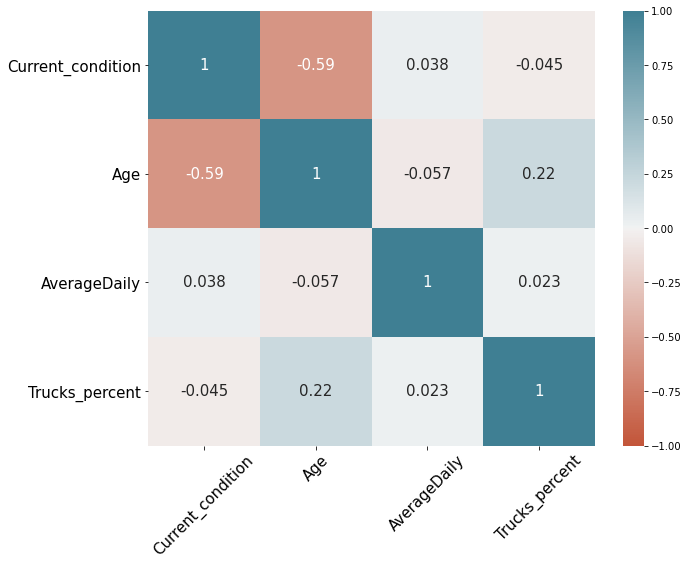

In [ ]:
_a2=bridges.loc[:,['Current_condition', 'Age', 'AverageDaily', 'Trucks_percent']]

fig,ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(_a2.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 15})
_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

Based on the above graph, we observe that:

* There is a modest negative correlation of -0.59 between the Age and the Current_condition variables.
* There is also a somewhat positive correlation of 0.22 between the Age and the Trucks_percent variables.
* The correlation between the AverageDaily and the Current_condition variables seems to be negligible.

However, a correlation near 0 can sometimes be misleading and falsely indicate that no correlation exists when in fact there is one. I plot the values of the variables as dots on a chart and visually inspect the charts to see if any additional correlations exist.

array([[<AxesSubplot:xlabel='Current_condition', ylabel='Current_condition'>,
        <AxesSubplot:xlabel='Age', ylabel='Current_condition'>,
        <AxesSubplot:xlabel='AverageDaily', ylabel='Current_condition'>,
        <AxesSubplot:xlabel='Trucks_percent', ylabel='Current_condition'>],
       [<AxesSubplot:xlabel='Current_condition', ylabel='Age'>,
        <AxesSubplot:xlabel='Age', ylabel='Age'>,
        <AxesSubplot:xlabel='AverageDaily', ylabel='Age'>,
        <AxesSubplot:xlabel='Trucks_percent', ylabel='Age'>],
       [<AxesSubplot:xlabel='Current_condition', ylabel='AverageDaily'>,
        <AxesSubplot:xlabel='Age', ylabel='AverageDaily'>,
        <AxesSubplot:xlabel='AverageDaily', ylabel='AverageDaily'>,
        <AxesSubplot:xlabel='Trucks_percent', ylabel='AverageDaily'>],
       [<AxesSubplot:xlabel='Current_condition', ylabel='Trucks_percent'>,
        <AxesSubplot:xlabel='Age', ylabel='Trucks_percent'>,
        <AxesSubplot:xlabel='AverageDaily', ylabel='Trucks_percent'

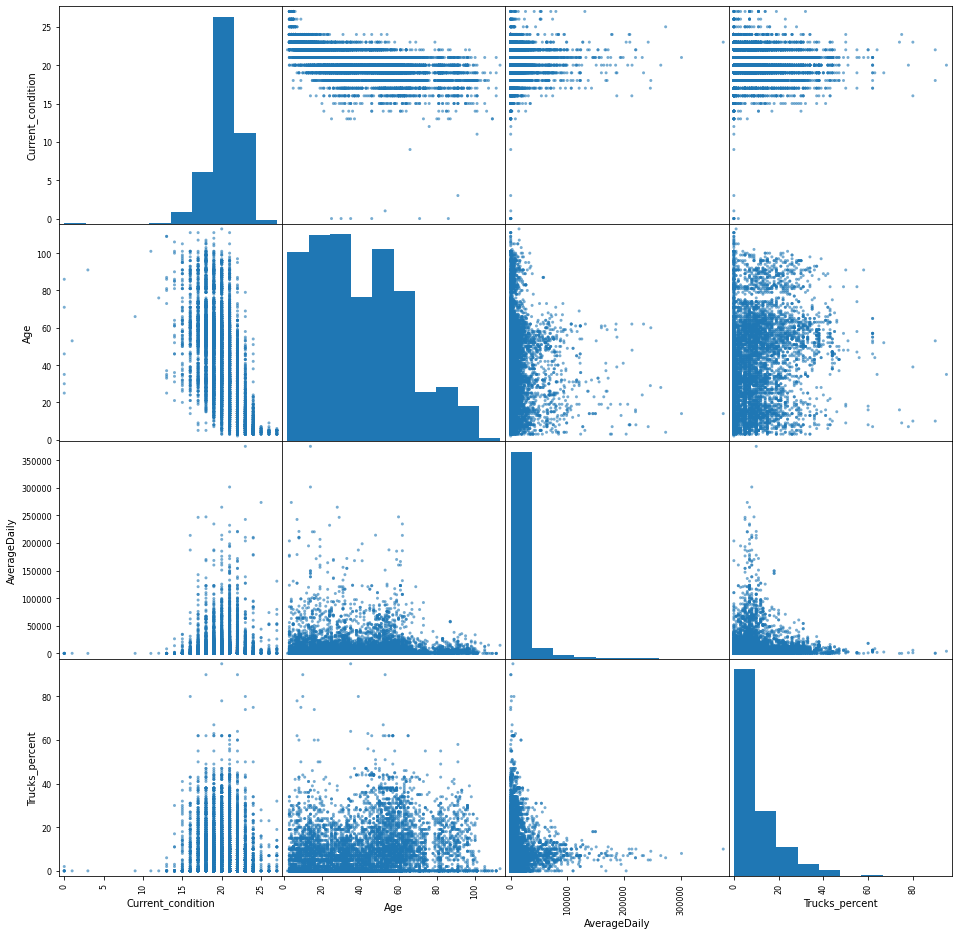

In [ ]:
pd.plotting.scatter_matrix(_a2.sample(frac=0.25),figsize=(16,16),alpha=0.6)

The above plots indicate that the pairs Current_condition-Trucks_percent, Current_condition-AverageDaily and AverageDaily-Trucks_percent may in fact be correlated in a non-linear way. This informs us that it could be more appropriate to utilise regression modelling of higher orders such as quadratic.

### Section 3.2: Comparison of continuous and categorical data

I now proceed to compare the numerical variables *Current_condition, Age, AverageDaily, Trucks_percent* with the categorical (non-numerical) variables *Material, Design* using boxplots. Note that the *Material* and *Design* variables are been processed using the classification scheme used in section 2.2.


Text(0.5, 0, '\n')

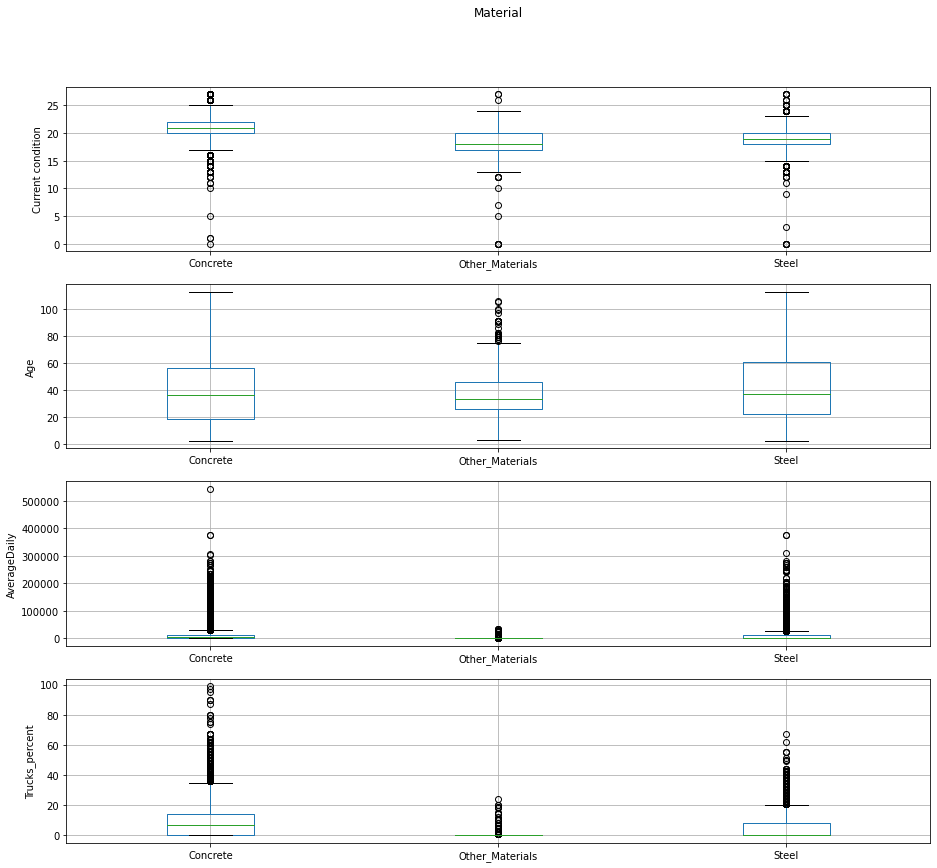

In [ ]:
fig, (a1, a2, a3, a4) = plt.subplots(4,1, figsize=(15,14))

bridges.boxplot(column='Current_condition', by='Material_New', ax=a1)
bridges.boxplot(column='Age', by='Material_New', ax=a2)
bridges.boxplot(column='AverageDaily', by='Material_New', ax=a3)
bridges.boxplot(column='Trucks_percent', by='Material_New', ax=a4)

fig.suptitle('Material')
[a.set_title('') for a in [a1, a2, a3, a4]]
a1.set_ylabel('Current condition')
a2.set_ylabel('Age')
a3.set_ylabel('AverageDaily')
a4.set_ylabel('Trucks_percent')
a1.set_xlabel('\n')
a2.set_xlabel('\n')
a3.set_xlabel('\n')
a4.set_xlabel('\n')

Text(0.5, 0, '\n')

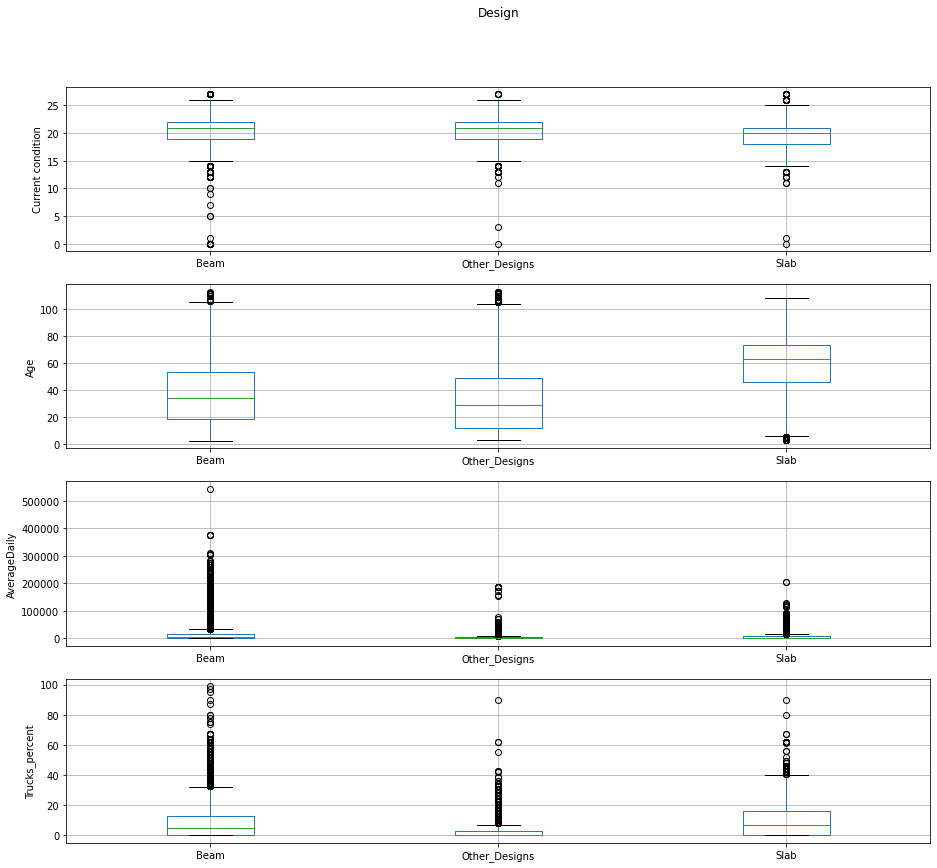

In [ ]:
fig, (a1, a2, a3, a4) = plt.subplots(4,1, figsize=(15,14))

bridges.boxplot(column='Current_condition', by='Design_New', ax=a1)
bridges.boxplot(column='Age', by='Design_New', ax=a2)
bridges.boxplot(column='AverageDaily', by='Design_New', ax=a3)
bridges.boxplot(column='Trucks_percent', by='Design_New', ax=a4)

fig.suptitle('Design')
[a.set_title('') for a in [a1, a2, a3, a4]]
a1.set_ylabel('Current condition')
a2.set_ylabel('Age')
a3.set_ylabel('AverageDaily')
a4.set_ylabel('Trucks_percent')
a1.set_xlabel('\n')
a2.set_xlabel('\n')
a3.set_xlabel('\n')
a4.set_xlabel('\n')

Based on the above charts, I conclude that generally there is not a strong correlation between what material type or design type it is used on a bridge and the impact of those towards the variables *Current_condition, Age, AverageDaily, Trucks_percent*. 

The only exceptions are that bridges made of *Concrete* tend to be somewhat higher in *Current_condition* compared to bridges made of *Steel* and *Other-Materials*, and bridges using the *Slab* design tend to be of higher *Age* compared to bridges made of *Beams* or *Other_Designs*.

### Section 3.3: Preliminary conclusions

From the above analysis, we predict that:
* The Age variable will have a modest negative impact on the target variable Current_condition.
* The Trucks_percent variable will have a somewhat positive impact on the target variable Current_condition
* The AverageDaily variable won't have much of an impact on the target variable Current_condition
* The Material and Design Variables and their categories won't have a large impact on the target variable Current_condition.

## Section 4: Regression Modelling

In this Section, I use the variables I prepared in Section 2 to create a linear regression model in the form of: 

$\begin{equation}
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5 + \beta_6 x_6 + \beta_7 x_7
\end{equation}$

where:

y: the target variable that we want to predict i.e. Current_condition.

$\begin{equation}
x_i \end{equation}$: the predictor variables that we use to predict the Current_condition i.e Age, AverageDaily,
       Trucks_percent, Steel, Other_Materials, Slab, Other_Designs.

$\begin{equation}
\beta_i \end{equation}$: the coefficients for each of the predictor variables.

$\begin{equation}
\beta_0 \end{equation}$: the intercept, a contant.

### Section 4.1: Computing the linear regression model

Below I carry out the linear regression model and compute all the relevant metrics.

In [ ]:
y = bridges.Current_condition
X = np.column_stack((bridges.Age,bridges.AverageDaily, bridges.Trucks_percent, \
                     Material_d.Steel, Material_d.Other_Materials, Design_d.Slab, Design_d.Other_Designs))

reg = LinearRegression().fit(X, y)
print('The R² coefficient of determination is: {:.3f}'.format(reg.score(X, y)))
print('The intercept is: {:.3f}'.format(reg.intercept_))

beta_Age, beta_AverageDaily, beta_Trucks_percent, beta_Steel, beta_Other_Materials, beta_Slab, beta_Other_Designs=reg.coef_

with np.printoptions(precision=9, suppress=True):
    print('\nThe regression coefficients are:', reg.coef_)
    
with np.printoptions(precision=9, suppress=True):
    print('\nThe regression model is y= {}{}*x{}*x+{}*x+{}*x{}*x{}*x{}*x'.format(reg.intercept_,reg.coef_[0],\
    reg.coef_[1],reg.coef_[2],reg.coef_[3],reg.coef_[4],reg.coef_[5],reg.coef_[6]))

The R² coefficient of determination is: 0.451
The intercept is: 22.491

The regression coefficients are: [-0.048486075 -0.000000657  0.005151631 -1.377449663 -2.788836804
 -0.075896757  0.140239492]

The regression model is y= 22.491142820004747-0.048486074754966725*x-6.565766752579156e-07*x+0.005151631193245219*x+-1.3774496632618538*x-2.788836804043207*x-0.07589675730456454*x0.14023949238612132*x


Using regression modelling, I generated the coefficient of determination R². Here we find a R²=0.451 which means our model is a moderately good fit.

### Section 4.2: Error Distribution

For the purposes of determining whether the model is a good fit for the data, we can calculate the substraction of the predicted model's current condition values from the actual current condition values. This will give us the errors of our model. The distribution of the errors is shown the graph below.

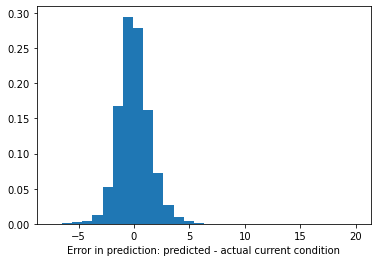

In [ ]:
y_hat = reg.predict(X)

fig, a1 = plt.subplots(1, 1)
residuals = y_hat - y
a1.hist(residuals, bins=30, density=True)
_ = a1.set_xlabel('Error in prediction: predicted - actual current condition')

The graph shows that the errors follow a roughly normal distrubition, with a mean value close to zero. This means our model is a good fit of the data.

Another statistic we can generate is the Root of the mean squared error or RMSE. The RMSE represents the square root of the variance of the residual errors. In general, an RMSE with a low value indicates a better fit of our model to the data.

In [ ]:
print('Root of the mean squared error: %.2f'% mean_squared_error(y, y_hat, squared=False))

Root of the mean squared error: 1.48


I observe that the RMSE of the modelling has a low value of 1.48. This adjusts our priors to the direction that the model is successful in predicting the current condition of the bridges.

Furthermore, I plot a graph of actual values against the predicted values. The better the model, the closer the points are to the blue line.

Text(0, 0.5, 'Actual Value')

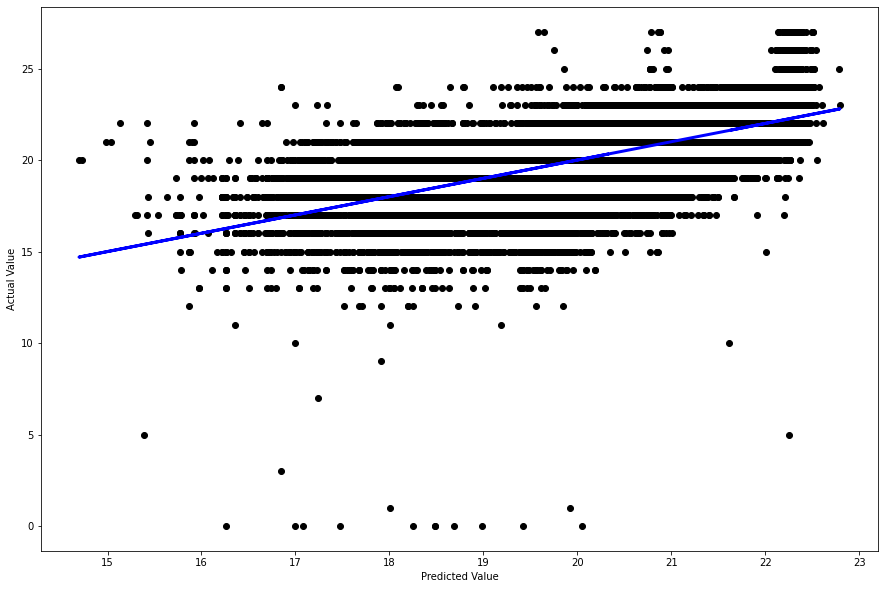

In [ ]:
fig, a = plt.subplots(1,1,figsize=(15,10))
a.scatter(y_hat, y,  color='black')
a.plot(y_hat, y_hat, color='blue', linewidth=3)

# two_std = residuals.std() * 2
# a.errorbar(y_hat, y, yerr=two_std, fmt='.k')

a.set_xlabel('Predicted Value')
a.set_ylabel('Actual Value')

I observe that the model does a decent job of generally predicting our values though there are several outliers.

### Section 4.3: Comparing the Coefficients

The coefficients I generated above aren't easily compared. They have different units and a few of the coefficients are very small to appropriately display. In order to properly compare the coefficients, I first look at the ranges of the predictor and target variables.

In [ ]:
Current_condition_range = bridges.Current_condition.quantile(0.9) - bridges.Current_condition.quantile(0.1)
Age_range = bridges.Age.quantile(0.9) - bridges.Age.quantile(0.1)
AverageDaily_range = bridges.AverageDaily.quantile(0.9) - bridges.AverageDaily.quantile(0.1)
Trucks_percent_range = bridges.Trucks_percent.quantile(0.9) - bridges.Trucks_percent.quantile(0.1)

print('Current_condition range (10th to 90th centile) is %3.0f' % Current_condition_range, '(unitless)')
print('\nAge range (10th to 90th centile) is %3.0f' % Age_range, 'years')
print('\nAverageDaily range (10th to 90th centile) is %3.0f' % AverageDaily_range, 'vehicles')
print('\nTrucks_percent range (10th to 90th centile) is %3.1f' % Trucks_percent_range, '%')
print('\nSteel range is 1 (unitless)')
print('\nOther_Materials range is 1 (unitless)')
print('\nSlab range is 1 (unitless)')
print('\nOther_Designs range is 1 (unitless)')

Current_condition range (10th to 90th centile) is   5 (unitless)

Age range (10th to 90th centile) is  61 years

AverageDaily range (10th to 90th centile) is 29560 vehicles

Trucks_percent range (10th to 90th centile) is 23.0 %

Steel range is 1 (unitless)

Other_Materials range is 1 (unitless)

Slab range is 1 (unitless)

Other_Designs range is 1 (unitless)


I now compute the change in the target variable's values as a percentage of its range that would result from the changing each of the predictor variable's values over its range. Using this method, I present a finer comparison of the significance of the predictors.

In [ ]:
print ('The change in Current_condition (as a percent of its range) given by the Age coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Age * Age_range) / Current_condition_range))

print ('The change in Current_condition (as a percent of its range) given by the AverageDaily coefficient (over its range) is %4.1f percent'
       % (100 * (beta_AverageDaily * AverageDaily_range) / Current_condition_range))

print ('The change in Current_condition (as a percent of its range) given by the Trucks_percent coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Trucks_percent * Trucks_percent_range) / Current_condition_range))

print ('The change in Current_condition (as a percent of its range) given by the Steel coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Steel * 1) / Current_condition_range))

print ('The change in Current_condition (as a percent of its range) given by the Other_Materials coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Other_Materials * 1) / Current_condition_range))

print ('The change in Current_condition (as a percent of its range) given by the Slab coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Slab * 1) / Current_condition_range))

print ('The change in Current_condition (as a percent of its range) given by the Other_Designs coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Other_Designs * 1) / Current_condition_range))

The change in Current_condition (as a percent of its range) given by the Age coefficient (over its range) is -59.2 percent
The change in Current_condition (as a percent of its range) given by the AverageDaily coefficient (over its range) is -0.4 percent
The change in Current_condition (as a percent of its range) given by the Trucks_percent coefficient (over its range) is  2.4 percent
The change in Current_condition (as a percent of its range) given by the Steel coefficient (over its range) is -27.5 percent
The change in Current_condition (as a percent of its range) given by the Other_Materials coefficient (over its range) is -55.8 percent
The change in Current_condition (as a percent of its range) given by the Slab coefficient (over its range) is -1.5 percent
The change in Current_condition (as a percent of its range) given by the Other_Designs coefficient (over its range) is  2.8 percent


### Section 4.4: Final conclusions and brief suggestions

The modelling of the linear regression I performed in the previous sections has proven to be a good fit for the given data. The proposed variables seem to have moderate predictive power. Out of the proposed variables, age and material seem to have the most influence in determining the current conditions of the bridges.

Moreover, while it does seem that both Age and the material Concrete seem to have predictive power, it is possible that our variables are confounded. More to the point, it is likely that bridges young in age usually tend to be built using concrete. Further analysis might exclude one or the other variable for the purposes of a regression model.

A future investigation on Texas bridges, whether it concerns the bridges's conditions or some other aspect, would benefit from including additional variables. For example, instead of merely including the condition of the deck, one could include whether the type of damage (if any) that has occured is due to enviromental causes, structural damage resulting from overloading or faulty deck contruction. This could inform the road authorities towards necessary actions for future bridge repairs.

Additional variables to consider is time since last maintenance and total number of repairs needed. It is not possible to determine from the present data whether a bridge in a good condition due to high durability or due to frequent repairs. If it's the latter, it can drive up long-term maintenance costs significantly and should be detected as soon as possible.